In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow as pa
import ast
from datasets import load_dataset, concatenate_datasets, Dataset
from collections import Counter
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

In [2]:
def error_type_map(example):
    # Any combination of error types is mapped into the same order.
    label_map = {
        "['extrinsic-NP']" : "['extrinsic-NP']",
        "['extrinsic-predicate']" : "['extrinsic-predicate']",
        "['intrinsic-NP']" : "['intrinsic-NP']",
        "['intrinsic-predicate']" : "['intrinsic-predicate']",
        'correct' : "['correct']",
        "['correct']" : "['correct']",

        "['extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']", 
        "['intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP']" : "['intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
         
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",

        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        }
    
    try:
        example['error_type'] = label_map[example['error_type']]
        return example
    
    except KeyError:
        return

In [3]:
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split

In [12]:
dataset = dataset.filter(lambda x: error_type_map(x) is not None)
dataset = dataset.map(error_type_map)

# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()
df['doc_length'] = df['doc'].apply(len)

Map: 100%|██████████| 4774/4774 [00:00<00:00, 8108.84 examples/s] 


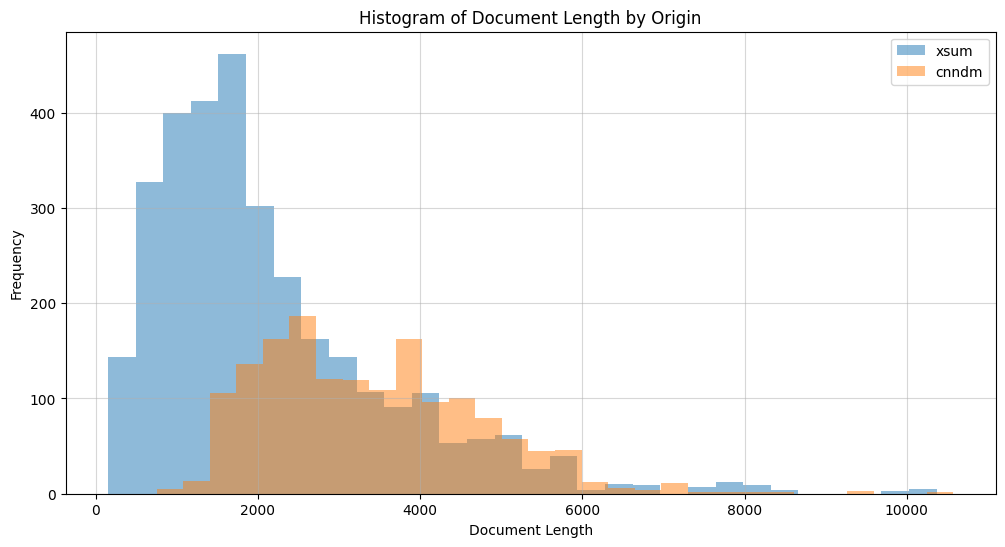

In [5]:
# Define the two origins you want to compare
origin_1 = 'xsum'  # Replace with the actual value for the first origin
origin_2 = 'cnndm'  # Replace with the actual value for the second origin

# Filter the DataFrame for the two origins
df_origin_1 = df[df['origin'] == origin_1]
df_origin_2 = df[df['origin'] == origin_2]

# Plot histograms of document length for each origin
plt.figure(figsize=(12, 6))
plt.hist(df_origin_1['doc_length'], bins=30, alpha=0.5, label=origin_1)
plt.hist(df_origin_2['doc_length'], bins=30, alpha=0.5, label=origin_2)

# Add labels and title
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Histogram of Document Length by Origin')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)

# Show the plot
plt.show()

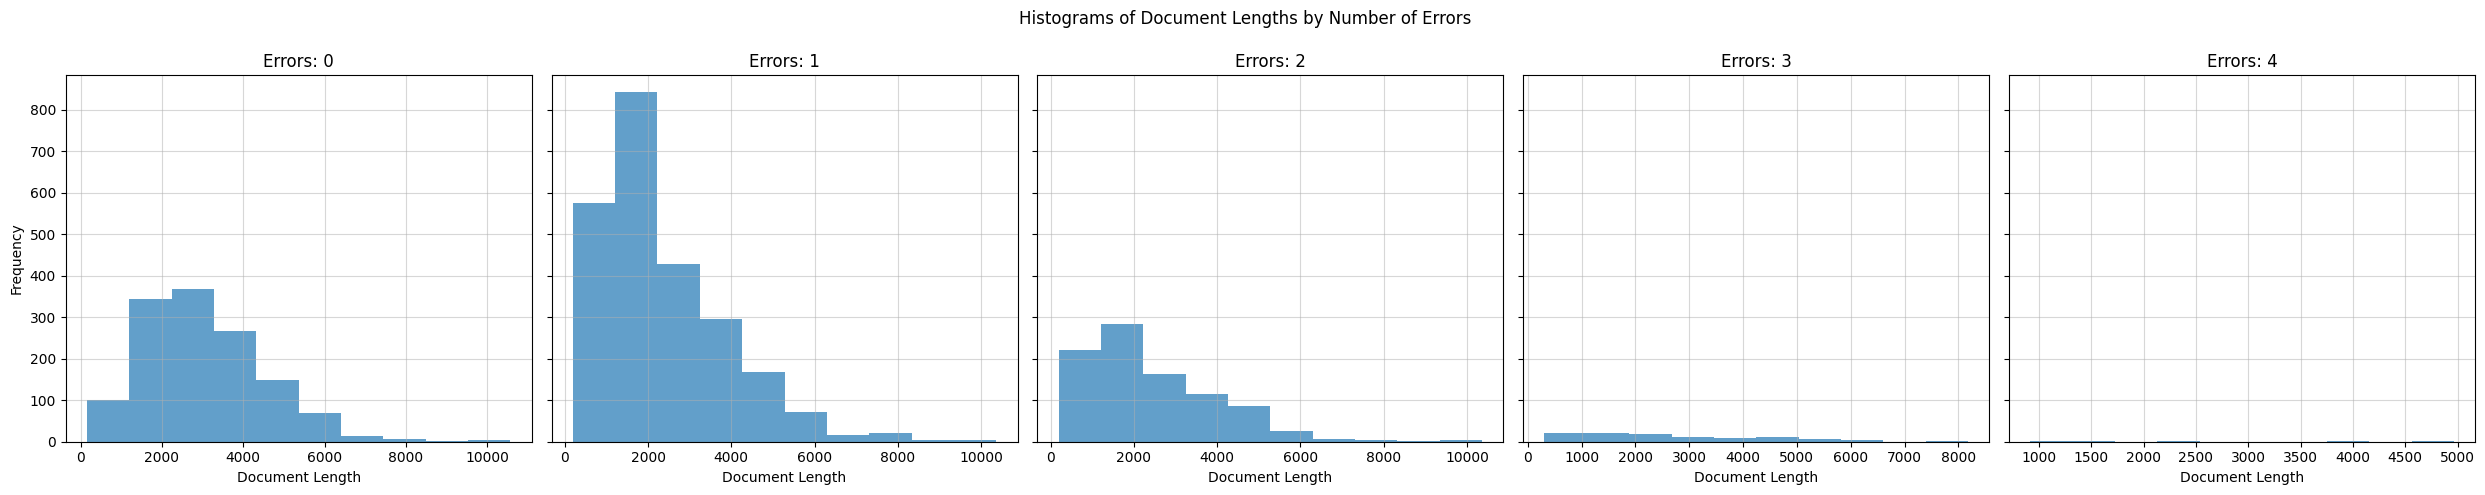

In [6]:
# Get num of errors vs length of doc

df['error_type_list'] = df['error_type'].apply(lambda x: ast.literal_eval(x))
df['num_errors'] = df['error_type_list'].apply(lambda x: len(x) if x != ['correct'] else 0)

# Define the range of unique error counts you want to plot
unique_error_counts = range(5)  # Assuming 'num_errors' ranges from 0 to 4

# Create subplots with 1 row and 5 columns (one for each error count)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)  # Share y-axis for better comparison

# Loop over each unique error count and corresponding subplot axis
for num_error, ax in zip(unique_error_counts, axes):
    # Filter the dataframe to include only rows with the current number of errors
    subset = df[df['num_errors'] == num_error]
    
    # Plot the histogram for the current subset of documents
    ax.hist(subset['doc_length'], bins=10, alpha=0.7)
    
    # Set title and labels for each subplot
    ax.set_title(f'Errors: {num_error}')
    ax.set_xlabel('Document Length')
    ax.grid(alpha=0.5)
    if num_error == 0:
        ax.set_ylabel('Frequency')  # Only set y-axis label on the first subplot

# Set a common title for the entire figure
fig.suptitle('Histograms of Document Lengths by Number of Errors')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the main title

# Show the plot
plt.show()

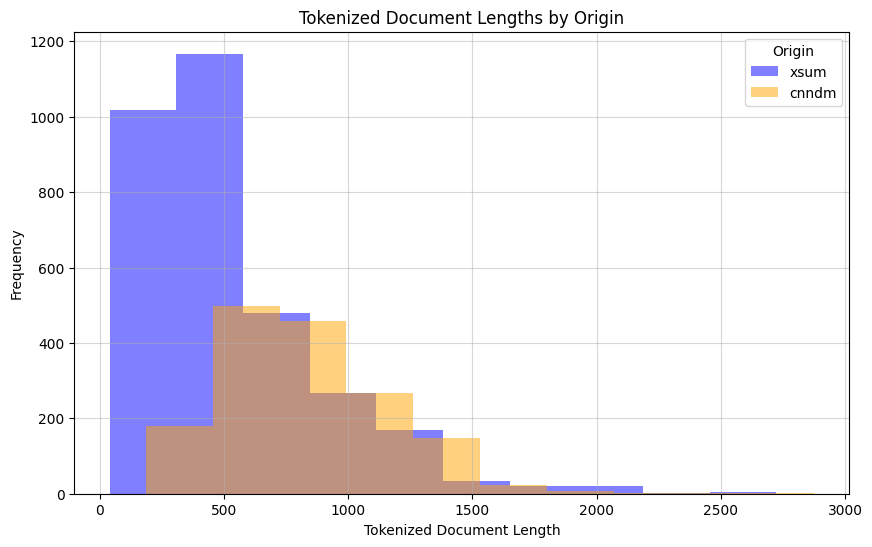

In [18]:
tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.3')

# Function to tokenize and calculate length
def tokenize_length(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Apply tokenization length calculation for each document
df['tokenized_length'] = df['doc'].apply(tokenize_length)

# Separate the data based on origin
origin1_data = df[df['origin'] == 'xsum']
origin2_data = df[df['origin'] == 'cnndm']

# Plot histograms of tokenized lengths for each origin on the same axis
plt.figure(figsize=(10, 6))

plt.hist(origin1_data['tokenized_length'], alpha=0.5, color='blue', label='xsum')
plt.hist(origin2_data['tokenized_length'], alpha=0.5, color='orange', label='cnndm')

plt.title('Tokenized Document Lengths by Origin')
plt.xlabel('Tokenized Document Length')
plt.ylabel('Frequency')
plt.legend(title='Origin')
plt.grid(alpha=0.5)

plt.show()

# Generate permenant test dataset

In [28]:
def undersampling(dataset, error_types=['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate'],
                    n=400):
    def sample_class(dataset, error_type, n):
        filtered = dataset.filter(lambda x: x['error_type'] == error_type)
        return filtered.shuffle(seed=42).select(range(min(n, len(filtered))))

    # Sample 400 examples from each class
    sampled_dataset = Dataset.from_dict({
        'id': [],
        'doc': [],
        'summ': [],
        'error_type': []
    })

    for error_type in error_types:
        sampled = sample_class(dataset, error_type, n)
        sampled_dataset = concatenate_datasets([sampled_dataset, sampled])

    # Shuffle the final dataset
    sampled_dataset = sampled_dataset.shuffle(seed=42)

    return sampled_dataset


def reformat_data_split_labels(dataset, dataset_name='Lislaam/AggreFact'):
    """Reformats the dataset to have the same format for all datasets for consistency.
    Args:
        dataset: dataset -- dataset to reformat
        dataset_name: str -- name of the dataset
    Returns:
        dataset: dataset -- reformatted dataset
    """
    def duplicate_and_label(example):
        """Duplicates examples with multiple error types, assigning one label per duplicate."""
        ids = []
        docs = []
        summs = []
        labels = []
        
        if example['errors'] is not None:
            try:
                lst = ast.literal_eval(example['errors'])
                for label in lst:
                    ids.append(example['id'])
                    docs.append(example['doc'])
                    summs.append(example['summ'])
                    labels.append(label)
            except ValueError:  # If 'errors' is not a list, e.g., it is 'correct'
                ids.append(example['id'])
                docs.append(example['doc'])
                summs.append(example['summ'])
                labels.append(example['errors'])
        return [{'id': id, 'doc': doc, 'summ': summ, 'error_type': label} for id, doc, summ, label in zip(ids, docs, summs, labels)]
    def process_in_chunks(dataset, chunk_size=10000, map_function=duplicate_and_label):
        chunked_tables = dataset.data.to_batches(max_chunksize=chunk_size)
        processed_chunks = []
        
        for chunk in chunked_tables:
            # Convert chunk to a PyArrow table
            chunk_table = pa.Table.from_batches([chunk])
            
            # Convert the chunk table to a pandas DataFrame
            chunk_df = chunk_table.to_pandas()
            
            if map_function:
                # Rename the column before splitting lists of errors into separate examples
                chunk_df = chunk_df.rename(columns={'error_type': 'errors'})
                
                # Apply the map function and flatten the result
                flattened_rows = chunk_df.apply(lambda row: map_function(row.to_dict()), axis=1).sum()
                
                # Convert the flattened list of dictionaries to a DataFrame
                chunk_df = pd.DataFrame(flattened_rows)
            
            processed_chunks.append(chunk_df)
        
        # Combine all processed chunks back into a single DataFrame
        combined_df = pd.concat(processed_chunks, ignore_index=True)
        
        return Dataset.from_pandas(combined_df)
    if dataset_name == "Lislaam/AggreFact":
        error_types = ['correct', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate']
        dataset = process_in_chunks(dataset)
        dataset = dataset.filter(lambda x: x['error_type'] in error_types)
        #dataset = dataset.filter(lambda x: len(x['doc']) < 1800)
        #dataset = dataset.map(error_type_map)
    else:
        raise ValueError(f"Dataset {dataset_name} not supported.")
    return dataset

In [33]:
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split
dataset = reformat_data_split_labels(dataset, 'Lislaam/AggreFact') # Get rid of non-standard error_type examples and split data
dataset = undersampling(dataset, n=100)

Filter: 100%|██████████| 5921/5921 [00:00<00:00, 93769.13 examples/s]


In [35]:
dataset['error_type']

['extrinsic-predicate',
 'intrinsic-NP',
 'extrinsic-predicate',
 'correct',
 'correct',
 'intrinsic-predicate',
 'correct',
 'extrinsic-predicate',
 'extrinsic-NP',
 'intrinsic-NP',
 'intrinsic-predicate',
 'intrinsic-predicate',
 'extrinsic-predicate',
 'intrinsic-NP',
 'extrinsic-NP',
 'intrinsic-NP',
 'intrinsic-predicate',
 'extrinsic-NP',
 'intrinsic-NP',
 'extrinsic-NP',
 'correct',
 'intrinsic-predicate',
 'extrinsic-predicate',
 'correct',
 'extrinsic-NP',
 'correct',
 'extrinsic-NP',
 'extrinsic-predicate',
 'intrinsic-NP',
 'intrinsic-predicate',
 'intrinsic-predicate',
 'correct',
 'intrinsic-predicate',
 'extrinsic-NP',
 'intrinsic-NP',
 'extrinsic-predicate',
 'correct',
 'intrinsic-predicate',
 'correct',
 'extrinsic-predicate',
 'extrinsic-predicate',
 'extrinsic-NP',
 'intrinsic-predicate',
 'intrinsic-NP',
 'correct',
 'extrinsic-predicate',
 'extrinsic-NP',
 'extrinsic-predicate',
 'extrinsic-NP',
 'intrinsic-NP',
 'extrinsic-predicate',
 'extrinsic-predicate',
 'int

In [39]:
# dataset.save_to_disk('data/eval')

Saving the dataset (1/1 shards): 100%|██████████| 500/500 [00:00<00:00, 63153.91 examples/s]
